In [5]:
!pip install mediapipe
import os
import pandas as pd
import numpy as np
import cv2
import mediapipe as mp
import math

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data preprocessing and Database construction

In [6]:
# Initialize mediapipe pose model
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

# Path to the directory containing videos
videos_path = '/kaggle/input/yoga-part-2/yoga_videos'
asanas = ['bhujangasana', 'padmasana', 'savasana', 'tadasana', 'trikonasana', 'vrikshasana']
# Initialize DataFrame and columns
columns = ['Left Elbow Angle', 'Right Elbow Angle', 'Left Shoulder Angle', 'Right Shoulder Angle', 'Left Knee Angle', 'Right Knee Angle', 'Label']
df = pd.DataFrame(columns=columns)


E0000 00:00:1700505735.990322     935 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700505735.990415     935 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700505735.990438     935 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700505735.990459     935 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700505735.990480     935 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700505735.99

In [7]:
def detectPose(image, pose, display=False):
    output_image = image.copy()
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(imageRGB)
    height, width, _ = image.shape
    rows = 33
    cols = 3
    landmarks = [[0 for _ in range(cols)] for _ in range(rows)]
#     landmarks = []
    drawing_spec = mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=6, circle_radius=16)
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS,landmark_drawing_spec=drawing_spec,connection_drawing_spec=drawing_spec)
        landmark = results.pose_landmarks.landmark
        for i in range(len(landmark)):
#         for landmark in results.pose_landmarks.landmark:
            landmarks[i] = ((landmark[i].x * width, landmark[i].y * height, landmark[i].z * width))

    if display:
        plt.figure(figsize=[22,22])
        plt.subplot(121); plt.imshow(image[:,:,::-1]); plt.title("Original Image"); plt.axis('off');
        plt.subplot(122); plt.imshow(output_image[:,:,::-1]); plt.title("Output Image"); plt.axis('off');
        plt.show()
    else:
        return output_image, landmarks

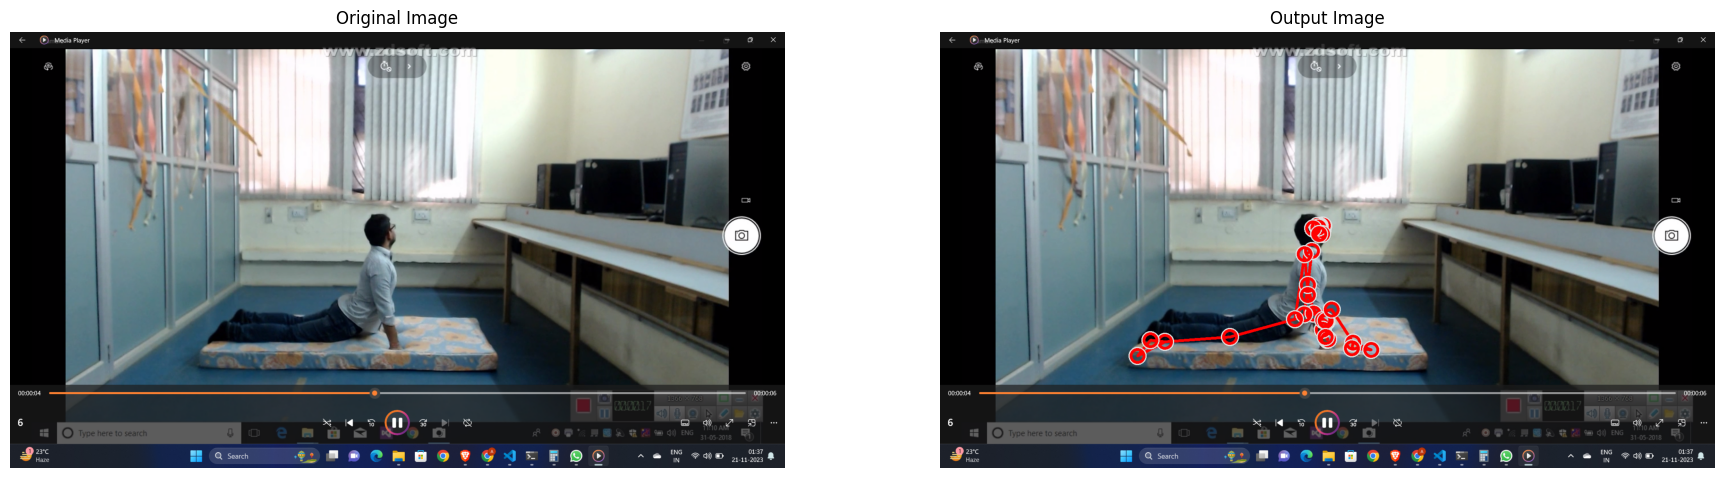

In [56]:
test_image_path = '/kaggle/input/bhujangasana-pose/sumit.png'
test_image = cv2.imread(test_image_path)
detectPose(test_image,pose,display=True)
test_ouput, test_landmark = detectPose(test_image,pose,display=False)

In [8]:
import matplotlib.pyplot as plt

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


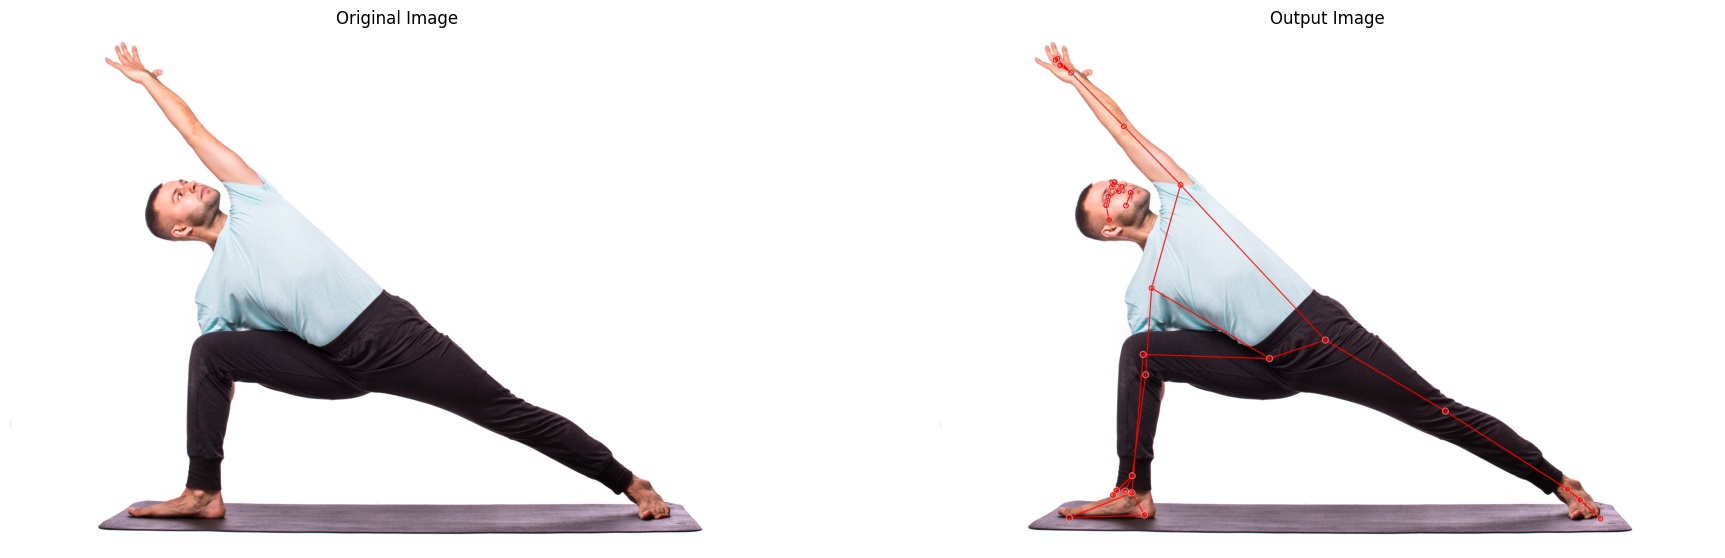

In [47]:
image_path = '/kaggle/input/yoga-pose-image/young-man-is-making-yoga-isolated-white-background.jpg'
image = cv2.imread(image_path)
detectPose(image,pose,display=True)
sample_output,sample_landmark=detectPose(image,pose,display=False)

In [6]:
print(len(sample_landmark))
print(len(sample_landmark[0]))

33
3


In [46]:
def calculateAngle(landmark1, landmark2, landmark3):
    x1, y1, z1 = landmark1
    x2, y2, z2 = landmark2
    x3, y3, z3 = landmark3
    
    angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))
    if angle < 0:
        angle += 360
    
    return angle

In [10]:
def classifyAngles(df, landmarks, label):
    left_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value])
    
    # Get the angle between the right shoulder, elbow and wrist points. 
    right_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value])   
    
    # Get the angle between the left elbow, shoulder and hip points. 
    left_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_HIP.value])

    # Get the angle between the right hip, shoulder and elbow points. 
    right_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value])

    # Get the angle between the left hip, knee and ankle points. 
    left_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value])

    # Get the angle between the right hip, knee and ankle points 
    right_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value])

#     df = df.append({'Left Elbow Angle': left_elbow_angle,
#                     'Right Elbow Angle': right_elbow_angle,
#                     'Left Shoulder Angle': left_shoulder_angle,
#                     'Right Shoulder Angle': right_shoulder_angle,
#                     'Left Knee Angle': left_knee_angle,
#                     'Right Knee Angle': right_knee_angle,
#                     'Label': label}, ignore_index=True)
    
    df.loc[len(df.index)] = [left_elbow_angle,right_elbow_angle,left_shoulder_angle,right_shoulder_angle,left_knee_angle,right_knee_angle,label] 

    return df

In [47]:

def classifyAngles_check(landmarks):
    left_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value])
    
    # Get the angle between the right shoulder, elbow and wrist points. 
    right_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value])   
    
    # Get the angle between the left elbow, shoulder and hip points. 
    left_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_HIP.value])

    # Get the angle between the right hip, shoulder and elbow points. 
    right_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value])

    # Get the angle between the left hip, knee and ankle points. 
    left_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value])

    # Get the angle between the right hip, knee and ankle points 
    right_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value])

    print(f"Left Elbow Angle: {left_elbow_angle}, "
          f"Right Elbow Angle: {right_elbow_angle}, "
          f"Left Shoulder Angle: {left_shoulder_angle}, "
          f"Right Shoulder Angle: {right_shoulder_angle}, "
          f"Left Knee Angle: {left_knee_angle}, "
          f"Right Knee Angle: {right_knee_angle}")
    
    return [left_elbow_angle,right_elbow_angle,left_shoulder_angle,right_shoulder_angle,left_knee_angle,right_knee_angle]


In [48]:
sample = classifyAngles_check(sample_landmark)
# sample_df = pd.DataFrame(columns=columns)
sample_dict = {'Left Elbow Angle':[],'Right Elbow Angle':[], 'Left Shoulder Angle':[], 'Right Shoulder Angle':[], 'Left Knee Angle':[], 'Right Knee Angle':[]}
sample_df = pd.DataFrame(sample_dict)
sample_df.loc[len(sample_df.index)] = list(sample)
print(sample_df)

Left Elbow Angle: 180.23925102927643, Right Elbow Angle: 185.37940371199593, Left Shoulder Angle: 181.28134593407876, Right Shoulder Angle: 62.06338507640061, Left Knee Angle: 182.13493676557826, Right Knee Angle: 92.89908776733623
   Left Elbow Angle  Right Elbow Angle  Left Shoulder Angle  \
0        180.239251         185.379404           181.281346   

   Right Shoulder Angle  Left Knee Angle  Right Knee Angle  
0             62.063385       182.134937         92.899088  


In [57]:
test = classifyAngles_check(test_landmark)

Left Elbow Angle: 177.2132409433389, Right Elbow Angle: 166.02341254025592, Left Shoulder Angle: 6.546181145932755, Right Shoulder Angle: 339.8386653738889, Left Knee Angle: 210.5100815306645, Right Knee Angle: 190.13175301917593


In [49]:
columns = ['Left Elbow Angle', 'Right Elbow Angle', 'Left Shoulder Angle', 'Right Shoulder Angle', 'Left Knee Angle', 'Right Knee Angle', 'Label']
dictionary = {'Left Elbow Angle':[],'Right Elbow Angle':[], 'Left Shoulder Angle':[], 'Right Shoulder Angle':[], 'Left Knee Angle':[], 'Right Knee Angle':[], 'Label':[]}
df = pd.DataFrame(dictionary)
df.head()

,Left Elbow Angle,Right Elbow Angle,Left Shoulder Angle,Right Shoulder Angle,Left Knee Angle,Right Knee Angle,Label


In [50]:
# Iterate through each video
for label in os.listdir(videos_path):
    video_path = os.path.join(videos_path, label)
    
    # Capture video
    cap = cv2.VideoCapture(video_path)
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    clip_duration = 120  # Duration to capture frames in seconds
    
    # Capture frames for the specified duration
    frames_to_capture = int(clip_duration * frame_rate)
    frames_collected = 0
    
    while frames_collected < frames_to_capture:
        ret, frame = cap.read()
        
        if not ret:
            break
        
        # Process frame to detect pose
        _, landmarks = detectPose(frame, pose, display=False)
        
        # Classify angles and add to DataFrame
        df = classifyAngles(df, landmarks, label)
        
        frames_collected += 1
        
    cap.release()

# Display or save DataFrame
print(df.head())

df.to_csv('yoga_poses_dataset.csv', index=False)

   Left Elbow Angle  Right Elbow Angle  Left Shoulder Angle  \
0          0.000000           0.000000             0.000000   
1        178.169750         191.422675           188.651106   
2        179.557834         189.613400           189.698087   
3        180.272471         188.596334           190.306413   
4        180.708749         187.774088           190.639329   

   Right Shoulder Angle  Left Knee Angle  Right Knee Angle         Label  
0              0.000000         0.000000          0.000000  tadasana.mp4  
1            184.720018       183.314380        178.573285  tadasana.mp4  
2            184.464328       182.852132        178.647634  tadasana.mp4  
3            184.668719       182.536304        178.708051  tadasana.mp4  
4            184.885938       182.350862        178.660152  tadasana.mp4  


# Split and Training

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [12]:
asanas = ['bhujangasana', 'padmasana', 'savasana', 'tadasana', 'trikonasana', 'vrikshasana']
labels = list()
for x in asanas:
    labels.append(x+'.mp4')
labels

['bhujangasana.mp4',
 'padmasana.mp4',
 'savasana.mp4',
 'tadasana.mp4',
 'trikonasana.mp4',
 'vrikshasana.mp4']

In [14]:
df = pd.read_csv('/kaggle/working/yoga_poses_dataset.csv')
print(df.head())

   Left Elbow Angle  Right Elbow Angle  Left Shoulder Angle  \
0          0.000000           0.000000             0.000000   
1        178.169750         191.422675           188.651106   
2        179.557834         189.613400           189.698087   
3        180.272471         188.596334           190.306413   
4        180.708749         187.774088           190.639329   

   Right Shoulder Angle  Left Knee Angle  Right Knee Angle         Label  
0              0.000000         0.000000          0.000000  tadasana.mp4  
1            184.720018       183.314380        178.573285  tadasana.mp4  
2            184.464328       182.852132        178.647634  tadasana.mp4  
3            184.668719       182.536304        178.708051  tadasana.mp4  
4            184.885938       182.350862        178.660152  tadasana.mp4  


In [15]:
label_map = {label:num for num,label in enumerate(labels)}
label_map

{'bhujangasana.mp4': 0,
 'padmasana.mp4': 1,
 'savasana.mp4': 2,
 'tadasana.mp4': 3,
 'trikonasana.mp4': 4,
 'vrikshasana.mp4': 5}

In [16]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
X = df.drop('Label', axis=1)  # Features
y = df['Label']  # Target

In [22]:
from sklearn.preprocessing import LabelEncoder
# Encode categorical labels using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [23]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)


# Model Training

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [18]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(6, activation='softmax')  # Adjust output neurons based on your classification categories
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1792      
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [19]:
from tensorflow.keras.callbacks import TensorBoard
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [24]:
history = model.fit(X_train, y_train, epochs=250, batch_size=64, validation_split=0.1, callbacks=[TensorBoard()])

Epoch 1/250
178/178 [==============================] - 6s 7ms/step - loss: 0.6054 - accuracy: 0.8108 - val_loss: 0.0797 - val_accuracy: 0.9833
Epoch 2/250
178/178 [==============================] - 1s 6ms/step - loss: 0.1921 - accuracy: 0.9470 - val_loss: 0.0466 - val_accuracy: 0.9841
Epoch 3/250
178/178 [==============================] - 1s 5ms/step - loss: 0.1446 - accuracy: 0.9596 - val_loss: 0.0465 - val_accuracy: 0.9857
Epoch 4/250
178/178 [==============================] - 1s 5ms/step - loss: 0.1143 - accuracy: 0.9701 - val_loss: 0.0366 - val_accuracy: 0.9881
Epoch 5/250
178/178 [==============================] - 1s 5ms/step - loss: 0.0970 - accuracy: 0.9735 - val_loss: 0.0256 - val_accuracy: 0.9921
Epoch 6/250
178/178 [==============================] - 1s 5ms/step - loss: 0.0905 - accuracy: 0.9752 - val_loss: 0.0269 - val_accuracy: 0.9913
Epoch 7/250
178/178 [==============================] - 1s 5ms/step - loss: 0.0839 - accuracy: 0.9750 - val_loss: 0.0324 - val_accuracy: 0.9897

In [26]:
res = model.predict(X_test)

169/169 [==============================] - 0s 2ms/step


In [58]:
numpy_test = np.array(test)
numpy_test = np.expand_dims(numpy_test, axis=0)
numpy_test
# test_res = model.predict(numpy_test)
# test_res

array([[177.21324094, 166.02341254,   6.54618115, 339.83866537,
        210.51008153, 190.13175302]])

In [59]:
output = loaded_model.predict(numpy_test)

# Print or use the output as needed
print(output)

1/1 [==============================] - 0s 20ms/step
[[9.9996638e-01 6.1500293e-07 3.2905897e-05 3.8168430e-10 4.2422251e-08
  5.5970890e-08]]


In [61]:
output_probabilities = np.array([[7.6863284e-07, 8.7133900e-09, 1.9854947e-06, 9.9997902e-01, 1.8023882e-05, 7.0292941e-08]])

# Get the predicted label (index of the highest probability)
predicted_label = np.argmax(output)
predicted_label

0

In [64]:
for lab,num in label_map.items():
    if num==predicted_label:
        print(lab)

bhujangasana.mp4


In [30]:
print(f'predicted asana: {asanas[np.argmax(res[60])]}')
print(f'actual asana: {asanas[np.argmax(y_test[60])]}')

predicted asana: trikonasana
actual asana: bhujangasana


In [21]:
print("Data types in X_train:")
print(X_train.dtypes)

print("\nData types in y_train:")
print(y_train.dtypes)


Data types in X_train:
Left Elbow Angle        float64
Right Elbow Angle       float64
Left Shoulder Angle     float64
Right Shoulder Angle    float64
Left Knee Angle         float64
Right Knee Angle        float64
dtype: object

Data types in y_train:
object


# Evaluation using Confusion Matrix and Accuracy

In [37]:
from sklearn.metrics import multilabel_confusion_matrix

# Assuming y_test is not one-hot encoded
yhat = model.predict(X_test)
yhat_labels = np.argmax(yhat, axis=1)  # Convert probabilities to integer labels

confusion_matrix = multilabel_confusion_matrix(y_true=y_test, y_pred=yhat_labels)
print("Multilabel Confusion Matrix:")
print(confusion_matrix)


169/169 [==============================] - 0s 2ms/step
Multilabel Confusion Matrix:
[[[4505    0]
  [   0  895]]

 [[4494    0]
  [   0  906]]

 [[4473    2]
  [   3  922]]

 [[4506    6]
  [   1  887]]

 [[4504    2]
  [   5  889]]

 [[4508    0]
  [   1  891]]]


In [38]:
from sklearn.metrics import accuracy_score

# Assuming y_test is not one-hot encoded
yhat = model.predict(X_test)
yhat_labels = np.argmax(yhat, axis=1)  # Convert probabilities to integer labels

accuracy = accuracy_score(y_true=y_test, y_pred=yhat_labels)
print("Accuracy Score:", accuracy)


169/169 [==============================] - 0s 2ms/step
Accuracy Score: 0.9981481481481481


In [36]:
y_test.shape

(5400,)

In [39]:
from sklearn.metrics import classification_report

# Assuming y_test is not one-hot encoded
yhat = model.predict(X_test)
yhat_labels = np.argmax(yhat, axis=1)  # Convert probabilities to integer labels

report = classification_report(y_true=y_test, y_pred=yhat_labels)
print("Classification Report:\n", report)


169/169 [==============================] - 0s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       895
           1       1.00      1.00      1.00       906
           2       1.00      1.00      1.00       925
           3       0.99      1.00      1.00       888
           4       1.00      0.99      1.00       894
           5       1.00      1.00      1.00       892

    accuracy                           1.00      5400
   macro avg       1.00      1.00      1.00      5400
weighted avg       1.00      1.00      1.00      5400



# Save Weights

In [40]:
model.save('action.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [41]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('action.h5')

# Setting up pipeline

In [66]:
def prediction_pipeline(test_image):
    # get the landmark
    realtime_output, realtime_landmark = detectPose(test_image, pose, display=False)
    
    # get the angles
    realtime_angles = classifyAngles_check(realtime_landmark)
    
    # create a numpy array for angles
    numpy_realtime = np.array(realtime_angles)
    numpy_realtime = np.expand_dims(numpy_realtime, axis=0)
    
    # predict the output
    output = loaded_model.predict(numpy_realtime)
    
    # get predicted label
    predicted_label = np.argmax(output)
    
    # find corresponding label name
    realtime_label = str()
    for lab, num in label_map.items():
        if num == predicted_label:
            # Return the whole string except the last 4 characters
            realtime_label = lab[:-4]

    return realtime_label

In [68]:
test_image_path = '/kaggle/input/bhujangasana-pose/sumit.png'
test_image = cv2.imread(test_image_path)
test_label_output = prediction_pipeline(test_image)
print(test_label_output)

Left Elbow Angle: 174.34427314469673, Right Elbow Angle: 166.0912251533275, Left Shoulder Angle: 12.679989781991587, Right Shoulder Angle: 331.0899347325693, Left Knee Angle: 236.45997256716072, Right Knee Angle: 189.11590525000068
1/1 [==============================] - 0s 18ms/step
bhujangasana


In [70]:
def detection_pipeline(test_image):
    detectPose(test_image, pose, display=True)

# Realtime Detection and Prediction using Webcam Feed

In [73]:
# Initialize OpenCV video capture
cap = cv2.VideoCapture(0)

# Variables to control the timer
timer_started = False
start_time = None

# Main loop to capture frames from the webcam
while True:
    ret, frame = cap.read()

    if not ret:
        break

    # Check for key press events
    key = cv2.waitKey(1) & 0xFF

    # Start the timer on 'c' key press
    if key == ord('c'):
        timer_started = True
        start_time = time.time()
        seconds = 0

    if timer_started:
        # Calculate elapsed time
        seconds = int(time.time() - start_time)

        # Display the timer on the frame
        cv2.putText(frame, f'Timer: {seconds}', (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        if seconds == 5:
            # Run classification function after 5 seconds
            result = prediction_pipeline(frame)
            
            # Display the classification result on the frame
            cv2.putText(frame, f'Predicted: {result}', (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 2)
            
        # Run detection function every second
        if seconds % 1 == 0:
            detection_pipeline(frame)

    # Show the frame
    cv2.imshow('Frame', frame)
    
    # Exit loop on 'q' key press
    if key == ord('q'):
        break

# Release the video capture and close all windows
cap.release()
# cv2.destroyAllWindows()

[ WARN:0@11022.087] global cap_v4l.cpp:982 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@11022.087] global obsensor_uvc_stream_channel.cpp:156 getStreamChannelGroup Camera index out of range
